### 1. 了解知道Dropout原理

Dropout：在前向传播的时候，让某个神经元的激活值以一定的概率p停止工作，这样可以使模型泛化性更强，因为它不会太依赖某些局部的特征。
![dropout](https://pic2.zhimg.com/80/v2-5530bdc5d49f9e261975521f8afd35e9_hd.jpg "dropout")

1. 首先随机（临时）删掉网络中一半的隐藏神经元，输入输出神经元保持不变（图3中虚线为部分临时被删除的神经元）

2. 然后把输入x通过修改后的网络前向传播，然后把得到的损失结果通过修改的网络反向传播。一小批训练样本执行完这个过程后，在没有被删除的神经元上按照随机梯度下降法更新对应的参数（w，b）。

3. 然后继续重复这一过程：恢复被删掉的神经元（此时被删除的神经元保持原样，而没有被删除的神经元已经有所更新）从隐藏层神经元中随机选择一个一半大小的子集临时删除掉（备份被删除神经元的参数）。对一小批训练样本，先前向传播然后反向传播损失并根据随机梯度下降法更新参数（w，b） （没有被删除的那一部分参数得到更新，删除的神经元参数保持被删除前的结果）。

4. 不断重复这一过程。

参考：[深度学习中Dropout原理解析](https://zhuanlan.zhihu.com/p/38200980)

### 4. PyTorch中实现dropout

参考：[PyTorch1.0实现L1，L2正则化及Dropout (附dropout原理的python实现)](https://zhuanlan.zhihu.com/p/62393636)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision 包收录了若干重要的公开数据集、网络模型和计算机视觉中的常用图像变换
import torchvision
import torchvision.transforms as transforms  

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

x.size() torch.Size([20, 1])


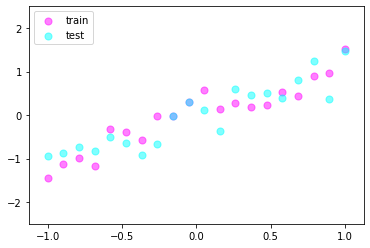

torch.Size([20, 1])

In [4]:
torch.manual_seed(1)    # Sets the seed for generating random numbers.reproducible

N_SAMPLES = 20
N_HIDDEN = 300

# training data
x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
print('x.size()',x.size())

# torch.normal(mean, std, out=None) → Tensor
y = x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))

# test data
test_x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
test_y = test_x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))

# show data
plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()
x.size()
torch.Size([20, 1])

In [5]:
net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1,N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN,N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN,1),
)

net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1,N_HIDDEN),
    torch.nn.Dropout(0.5), # 0.5的概率失活
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN,N_HIDDEN),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN,1),
)

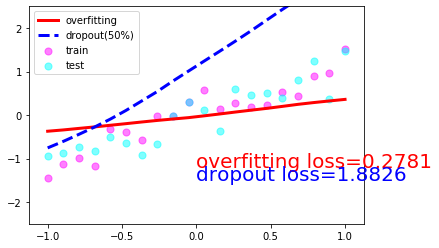

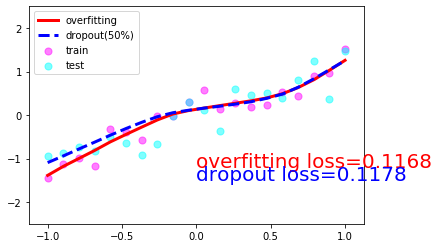

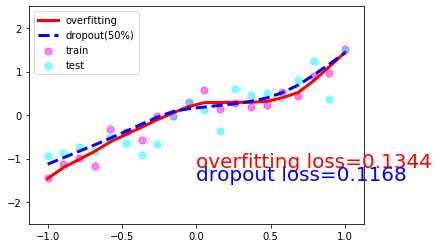

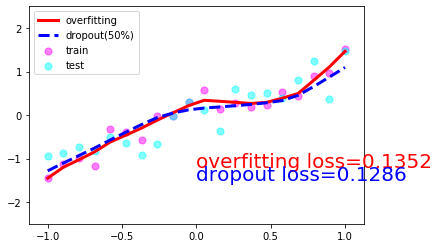

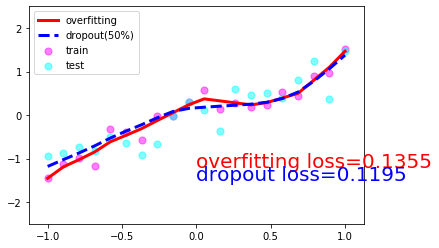

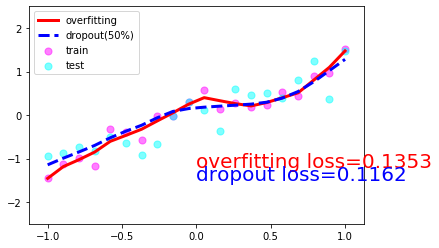

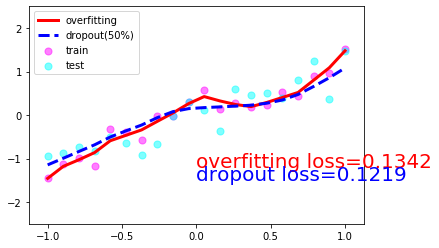

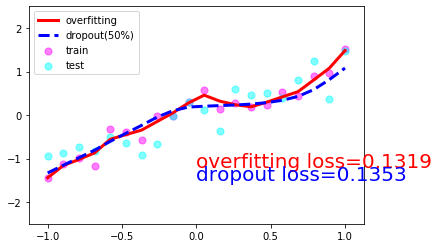

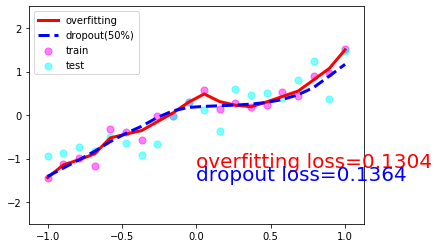

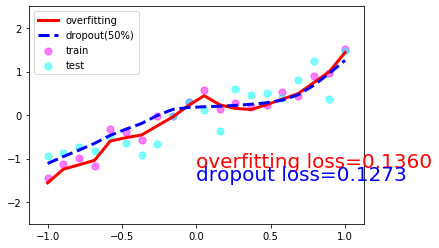

In [6]:
optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(),lr=0.001)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(),lr=0.01)
loss = torch.nn.MSELoss()

for epoch in range(500):
    pred_ofit= net_overfitting(x)
    pred_drop= net_dropped(x)

    loss_ofit = loss(pred_ofit,y)
    loss_drop = loss(pred_drop,y)

    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()

    loss_ofit.backward()
    loss_drop.backward()

    optimizer_ofit.step()
    optimizer_drop.step()

    if epoch%50 ==0 :
        net_overfitting.eval() # 将神经网络转换成测试形式,此时不会对神经网络dropout
        net_dropped.eval() # 此时不会对神经网络dropout

        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)

        # show data
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
        plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        plt.text(0, -1.2, 'overfitting loss=%.4f' % loss(test_pred_ofit, test_y).data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.text(0, -1.5, 'dropout loss=%.4f' % loss(test_pred_drop, test_y).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
        plt.legend(loc='upper left')
        plt.ylim((-2.5, 2.5))
        plt.pause(0.1)


        net_overfitting.train()
        net_dropped.train()

plt.ioff()
plt.show()

### 3. Dropout的numpy实现

In [14]:
""" 普通版随机失活: 不推荐实现  """
p = 0.5 # 激活神经元激活神经元激活神经元（重要的事情说三遍）的概率.   p值更高 = 随机失活更弱
def train_step(X):
    """ X中是输入数据 """
    # 3层neural network的前向传播
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = np.random.rand(*H1.shape) < p # 第一个dropout mask
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = np.random.rand(*H2.shape) < p # 第二个dropout mask
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
    # 反向传播:计算梯度... (略)
    # 进行参数更新... (略)

def predict(X):
    # 前向传播时模型集成
    H1 = np.maximum(0, np.dot(W1, X) + b1) * p # 注意：激活数据要乘以p
    H2 = np.maximum(0, np.dot(W2, H1) + b2) * p # 注意：激活数据要乘以p
    out = np.dot(W3, H2) + b3

In [13]:
"""
inverted dropout（反向随机失活）: 推荐实现方式.
在训练的时候drop和调整数值范围，测试时不用任何改变.
"""
p = 0.5 # 激活神经元的概率. p值更高 = 随机失活更弱

def train_step(X):
    # 3层neural network的前向传播
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = (np.random.rand(*H1.shape) < p) / p # 第一个dropout mask. 注意/p!
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = (np.random.rand(*H2.shape) < p) / p # 第二个dropout mask. 注意/p!
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
    # 反向传播:计算梯度... (略)
    # 进行参数更新... (略)

def predict(X):
    # 前向传播时模型集成
    H1 = np.maximum(0, np.dot(W1, X) + b1) # 不用数值范围调整了
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    out = np.dot(W3, H2) + b3

2. PyTorch中实现dropout